In [1]:
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import find_extremas, filter_extremas, detect_side, analyse_each_rep
from JointAngles import JointAngles
import numpy as np
import math
import glob
import os
import itertools
import pickle
import matplotlib.pyplot as plt



Starting...
Keypoints from folder: bicep_curl_15_1rep
Detected arm: right
angle_diffs [13.40689347 17.16965015  0.34493933]
angle_diffs [0.7380304  0.70253404 0.31486458 0.61551235]

----------------------------Filtering minimas-------------------------------------

Size of minima array: 0
------------------------------------------------------------------------------------------


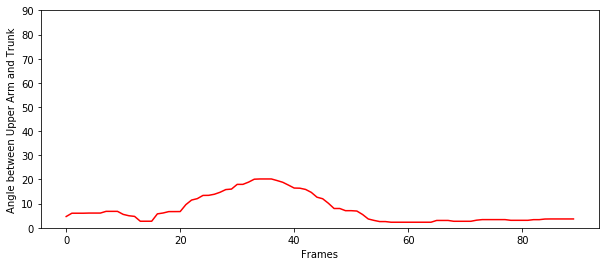

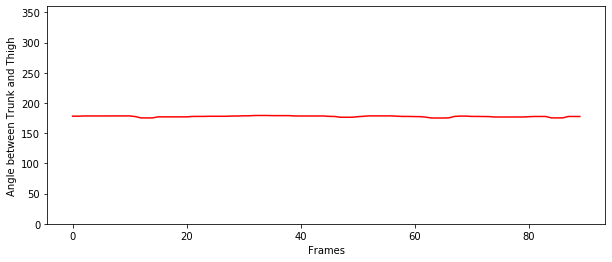

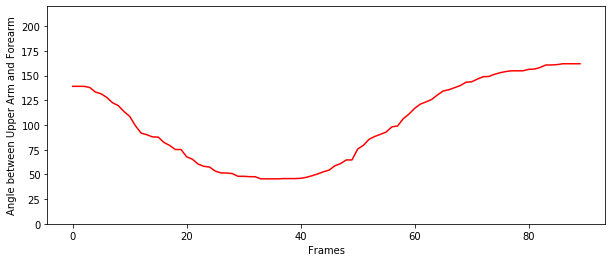

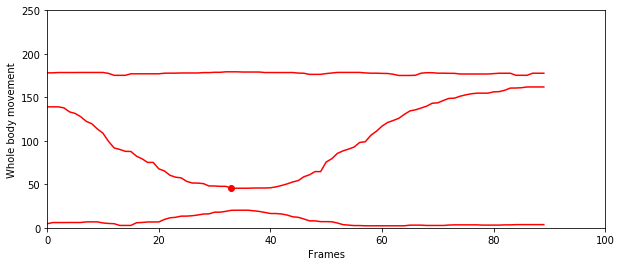

In [18]:
# modify this path for other videos 
input_folder = "C:\\Users\\kvash\\Documents\\GitHub\\IndividualProject\\test_fig\\bicep_curl"
#input_folder = "C:\\Users\\kvash\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\bicep_curl"
#input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\bicep_curl'
folder_paths = glob.glob(os.path.join(input_folder, 'bicep_curl_15_1rep'))     
min_upper_arm_forearm = [] 
max_upper_arm_forearm = []
min_upper_arm_trunk = []
max_upper_arm_trunk = []
min_trunk_knee = []
max_trunk_knee = []


for folder in folder_paths:
    print("Starting..." + "\nKeypoints from folder: " + os.path.basename(folder))
    video_name = os.path.basename(folder)
    frame_poses = parse_frames(folder)
    
    joint_angles = JointAngles('bicep_curl', frame_poses)
    print('Detected arm: ' + joint_angles.side)

    upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
    
   
    upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
    
    trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
    trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
    
    # Find upper arm and trunk maximum angles to detect wrong form 
    upArm_trunk_maximas = find_extremas(upArm_trunk_angles_filtered)
    upArm_trunk_maximas = filter_extremas(upArm_trunk_angles_filtered, upArm_trunk_maximas)
    indexesmax1 = np.array([np.argwhere(upArm_trunk_angles_filtered == maxima)[0][0] for maxima in upArm_trunk_maximas])
    # print("Largest angles between upper arm and trunk: " + str(upArm_trunk_maximas))

    # Find trunk and knee maximum angles to detect wrong form 
    trunk_knee_maximas = find_extremas(trunk_knee_angles_filtered)
    trunk_knee_maximas = filter_extremas(trunk_knee_angles_filtered, trunk_knee_maximas)
    indexesmax2 = np.array([np.argwhere(trunk_knee_angles_filtered == maxima)[0][0] for maxima in trunk_knee_maximas])
   
    # print("Largest angles between trunk and knee: " + str(trunk_knee_maximas))

    # Count repetitions
    upArm_forearm_minimas = find_extremas(upArm_forearm_angles_filtered, maxima=False)  
    upArm_forearm_minimas = filter_extremas(upArm_forearm_angles_filtered, upArm_forearm_minimas, maxima=False)
    indexesmin = np.array([np.argwhere(upArm_forearm_angles_filtered == minima)[0][0] for minima in upArm_forearm_minimas])
   
    
    
    # Find upper arm and forearm minimum points to count reps 
    upArm_forearm_maximas = find_extremas(upArm_forearm_angles_filtered)
    print('\n----------------------------Filtering minimas-------------------------------------')
    upArm_forearm_maximas = filter_extremas(upArm_forearm_angles_filtered, upArm_forearm_maximas)
    indexesmax3 = np.array([np.argwhere(upArm_forearm_angles_filtered == maxima)[0][0] for maxima in upArm_forearm_maximas])
    print("\nSize of minima array: " + str(upArm_forearm_maximas.size))
    print('-'*90)
   
    # Plot 1
    plt.figure(figsize=(10,4))
    #plt.plot(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.plot(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=1)
    #plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90)
    
    # Annontate maxima points
    #plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.show()
    
    # Plot 2
    plt.figure(figsize=(10,4))
    #plt.plot(np.arange(trunk_knee_angles.shape[0]), trunk_knee_angles, alpha=0.5)
    plt.plot(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=1)
    #plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Trunk and Thigh')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,360)
    
    # Annontate maxima points
    #plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.show()

    # Plot 3
    plt.figure(figsize=(10,4))
    #plt.plot(np.arange(upArm_forearm_angles.shape[0]), upArm_forearm_angles, c='r', alpha=1)
    plt.plot(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=1)
    #plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,220) 
    
    # Annotate minima apoints on the graph   
    #max_points = upArm_forearm_angles_filtered[indexesmax3]
    #min_points = upArm_forearm_angles_filtered[indexesmin]
    #plt.plot(indexesmin, min_points, 'ro')
    #plt.plot(indexesmax3, max_points, 'ko')

    """
        # Annotate local maximas
        for maxp, indx in zip(max_points, indexesmax3):
            plt.annotate('local max', xy=(indx, maxp), xytext=(indx, maxp+25),
                    arrowprops=dict(facecolor='black', shrink=0.05))

        # Annotate local minimas
        for minp, indx in zip(min_points, indexesmin):
            plt.annotate('local min', xy=(indx, minp), xytext=(indx, minp-35),
                    arrowprops=dict(facecolor='black', shrink=0.05))     
    """
    plt.show()

    # Plot 4
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r')
    plt.plot(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r')
    plt.plot(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r')
    #plt.title('bicep_curl_correct_15__10')
    plt.xlabel('Frames')
    plt.ylabel('Whole body movement')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,250) 
  
    # Annotate minima apoints      
    plt.plot(indexesmin, upArm_forearm_angles_filtered[indexesmin], 'ro')
    #plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    #plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    #plt.plot(indexesmax3, upArm_forearm_angles_filtered[indexesmax3], 'ko')
    
    plt.show()
   
    """
    min_upper_arm_forearm1, max_upper_arm_forearm1, min_upper_arm_trunk1, max_upper_arm_trunk1, min_trunk_knee1, max_trunk_knee1 = analyse_each_rep(exercise='bicep_curl', mode='thresholds', 
                                                                                                                                         extremas1=upArm_forearm_maximas, 
                                                                                                                                         uf_angles1=upArm_forearm_angles_filtered, 
                                                                                                                                         ut_angles1=upArm_trunk_angles_filtered, 
                                                                                                                                         tk_angles1=trunk_knee_angles_filtered)
    
    """
    analyse_each_rep(exercise='bicep_curl', mode='analysis', extremas1=upArm_forearm_maximas, 
                     uf_angles1=upArm_forearm_angles_filtered, ut_angles1=upArm_trunk_angles_filtered, 
                     tk_angles1=trunk_knee_angles_filtered)
    """
    min_upper_arm_forearm = min_upper_arm_forearm + min_upper_arm_forearm1
    max_upper_arm_forearm = max_upper_arm_forearm + max_upper_arm_forearm1
    min_upper_arm_trunk = min_upper_arm_trunk + min_upper_arm_trunk1
    max_upper_arm_trunk = max_upper_arm_trunk + max_upper_arm_trunk1
    min_trunk_knee = min_trunk_knee + min_trunk_knee1
    max_trunk_knee = max_trunk_knee + max_trunk_knee1
    
    print('\n' + '='*120 + '\n')


print('Minimum in min Upper Arm Forearm threshold: ' + str(min(min_upper_arm_forearm)))
print('Maximum in min Upper Arm Forearm threshold: ' + str(max(min_upper_arm_forearm)))
print('Minimum in max Upper Arm Forearm threshold: ' + str(min(max_upper_arm_forearm)))
print('Maximum in max Upper Arm Forearm threshold: ' + str(max(max_upper_arm_forearm)))
print('Minimum value in minimum Upper Arm Trunk angles: ' + str(min(min_upper_arm_trunk)))
print('Maximum value in maximum Upper Arm Trunk angles: ' + str(max(max_upper_arm_trunk)))
print('Minimum Trunk Knee threshold: ' + str(min(min_trunk_knee)))
print('Maximum Trunk Knee threshold: ' + str(max(max_trunk_knee)))
 """